In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import seaborn as sns
import momepy
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# London

## Roads

The TQ file is still too large so I've manually clipped it to the london boroughs shapefile myself with QGIS

The problem is that those shapefiles exclude the Thames, and any water bodies, cutting off any roads that cross them. This is a limitation in centrality analysis...

also simplified manually with qgis: Douglas-Peucker, 100 meters

In [2]:
# This takes a min
london = gpd.read_file('data/london/roads/simplified/a_roads_simplified.shp')

In [3]:
london.head()

,FID,geometry
0,0,"LINESTRING (521572.000 167573.000, 521620.000 ..."
1,1,"LINESTRING (521620.000 167540.000, 521608.000 ..."
2,2,"LINESTRING (521406.000 167544.000, 521555.010 ..."
3,3,"LINESTRING (521572.000 167573.000, 521555.010 ..."
4,4,"LINESTRING (521608.000 167590.000, 521572.000 ..."


In [4]:
#london.function.unique()

In [5]:
lon_major = london#.query('function in ["A Road", "Motorway"]') #"B Road"S
lon_major

,FID,geometry
0,0,"LINESTRING (521572.000 167573.000, 521620.000 ..."
1,1,"LINESTRING (521620.000 167540.000, 521608.000 ..."
2,2,"LINESTRING (521406.000 167544.000, 521555.010 ..."
3,3,"LINESTRING (521572.000 167573.000, 521555.010 ..."
4,4,"LINESTRING (521608.000 167590.000, 521572.000 ..."
...,...,...
25344,25344,"LINESTRING (531789.230 180953.360, 531786.000 ..."
25345,25345,"LINESTRING (531654.440 180937.920, 531658.070 ..."
25346,25346,"LINESTRING (531712.130 180941.360, 531658.070 ..."
25347,25347,"LINESTRING (531201.020 180818.120, 531415.670 ..."


<AxesSubplot:>

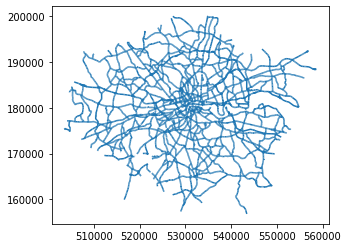

In [6]:
lon_major.plot()

In [7]:
lon_major.geometry.apply(lambda x: x.geom_type).unique()

array(['LineString'], dtype=object)

Some of the geometry are MultiLineStrings, so they need to be splitted...

In [8]:
# literally no mention of index_parts in pandas_dev github...
exploded = lon_major[lon_major.geometry.geom_type == 'MultiLineString'].explode(index_parts=False)
exploded.head()

,FID,geometry


In [9]:
lon_major_fixed = pd.concat([lon_major[lon_major.geometry.geom_type != 'MultiLineString'], exploded])
lon_major_fixed

,FID,geometry
0,0,"LINESTRING (521572.000 167573.000, 521620.000 ..."
1,1,"LINESTRING (521620.000 167540.000, 521608.000 ..."
2,2,"LINESTRING (521406.000 167544.000, 521555.010 ..."
3,3,"LINESTRING (521572.000 167573.000, 521555.010 ..."
4,4,"LINESTRING (521608.000 167590.000, 521572.000 ..."
...,...,...
25344,25344,"LINESTRING (531789.230 180953.360, 531786.000 ..."
25345,25345,"LINESTRING (531654.440 180937.920, 531658.070 ..."
25346,25346,"LINESTRING (531712.130 180941.360, 531658.070 ..."
25347,25347,"LINESTRING (531201.020 180818.120, 531415.670 ..."


In [10]:
g_l = momepy.gdf_to_nx(lon_major_fixed, approach="primal")

# Warning: takes forever (like 1 hour)

In [11]:
primal = momepy.closeness_centrality(g_l, name='closeness_global', weight='mm_len')
with open('london_edge_centrality.pkl', 'wb') as f:
    pickle.dump(primal, f)

In [12]:
# if it is dumped, load it instead of calculating
with open('london_edge_centrality.pkl', 'rb') as f:
    primal = pickle.load(f)

In [13]:
momepy.mean_nodes(primal, 'closeness_global')
primal_gdf = momepy.nx_to_gdf(primal, points=False)

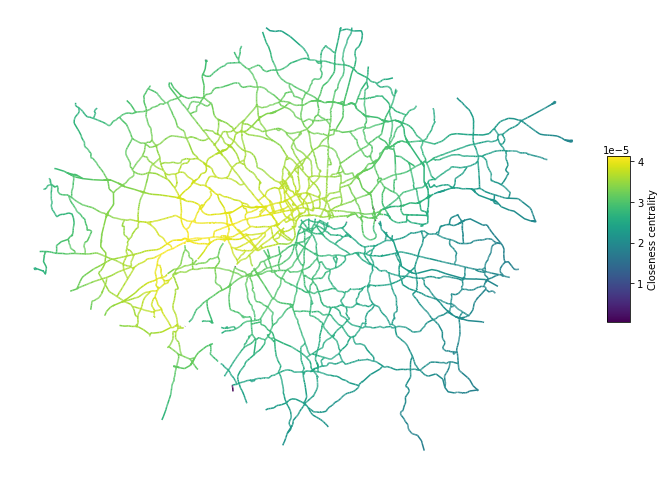

In [14]:
_, ax = plt.subplots(figsize=(10, 7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cax.set_aspect(7)

primal_gdf.plot('closeness_global', ax=ax, legend=True, cax=cax, legend_kwds={'label': 'Closeness centrality'})
plt.tight_layout()
ax.axis('off')
plt.savefig('cc_l_edge.png')

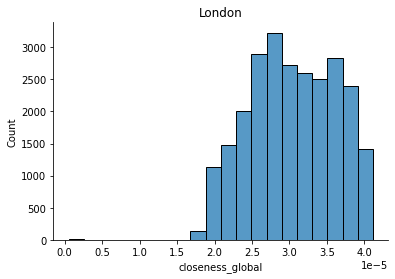

In [15]:
sns.histplot(x=primal_gdf.closeness_global, bins=20)
sns.despine()
plt.title('London')
plt.savefig('figures/l_cc_hist.png')

In [16]:
primal_gdf[['closeness_global', 'geometry']].to_csv('gen/london_c.csv')

# No longer need this part as edges are better
# Warning: takes forever (like 30 mins)

In [11]:
# node closeness centrality
#node_centrality = nx.closeness_centrality(g_l)

# Saving it to avoid expensive re-calculation
#with open('london_road_centrality.pkl', 'wb') as f:
#    pickle.dump(node_centrality, f)

# To read it again: run
with open('london_road_centrality.pkl', 'rb') as f:
    node_centrality = pickle.load(f)

In [12]:
l_nc = pd.DataFrame(data=pd.Series(node_centrality), columns=['cc'])

In [13]:
l_nc['colors'] = ox.plot.get_colors(n=len(node_centrality), cmap='inferno', start=0.2)
l_nc.reset_index(inplace=True)
l_nc.rename(columns={'level_0': 'x', 'level_1': 'y'}, inplace=True)
l_nc

,x,y,level_2,cc,colors
0,522524.570000,165820.080000,0.0,0.002838,"(0.258234, 0.038571, 0.406485, 1.0)"
1,522594.000000,165769.000000,0.0,0.002831,"(0.258234, 0.038571, 0.406485, 1.0)"
2,522460.000000,165868.000000,0.0,0.002844,"(0.258234, 0.038571, 0.406485, 1.0)"
3,522392.000000,165917.000000,0.0,0.002850,"(0.258234, 0.038571, 0.406485, 1.0)"
4,522650.300000,165726.210000,0.0,0.002819,"(0.258234, 0.038571, 0.406485, 1.0)"
...,...,...,...,...,...
23891,536981.885591,180347.652019,0.0,0.002677,"(0.988362, 0.998364, 0.644924, 1.0)"
23892,544451.449223,183038.834413,0.0,0.002194,"(0.988362, 0.998364, 0.644924, 1.0)"
23893,544392.226710,183008.458708,0.0,0.002736,"(0.988362, 0.998364, 0.644924, 1.0)"
23894,543733.296971,184059.028014,0.0,0.002773,"(0.988362, 0.998364, 0.644924, 1.0)"


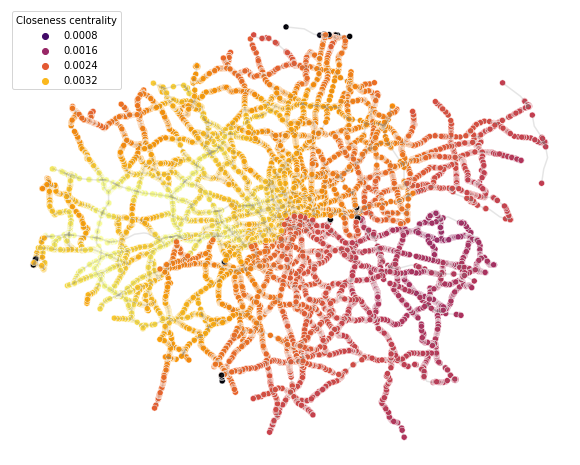

In [14]:
_, ax = plt.subplots(figsize=(10, 7))
lon_major.plot(ax=ax, color='grey', alpha=0.2)
sns.scatterplot(x=l_nc.x, y=l_nc.y, hue=l_nc.cc, palette='inferno', ax=ax)
plt.tight_layout()
plt.axis('off')
ax.legend(title='Closeness centrality')
plt.savefig('cc_l.png')

<AxesSubplot:ylabel='Frequency'>

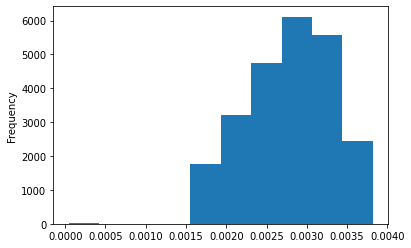

In [15]:
l_nc.cc.plot.hist()